This Jupyter Notebook is meant to be accessed via Google Colab and will be the main method to train models on Google Colab.

In [6]:
# primary importing code block to utilize the python files
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from pydub import AudioSegment   # main class from pydub package used to upload mp3 into Python and then get a NumPy array
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed
import librosa as lb             # loads the librosa package
import librosa.display
from src.configs import *
from src.utils import MusicAlignedTab, create_FullSet_df, one_hot_encode, collapse_class, clean_labels
from src.utils import save_drum_tabber_model, load_drum_tabber_model, create_configs_dict
from src.dataset import Dataset
import src.utils as ut

In [245]:
mat = MusicAlignedTab('mookies_last_christmas')
df = mat.MAT

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [246]:
df = clean_labels(df)
MusicAlignedTab.labels_summary(df)
df = collapse_class(df, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(df)

---dataframe.describe() without blank_chars---
          tk   BD   SD   HH  RD   CC C2  LT  MT  HT
count   1936  455  227  217  58  198  3  50  59  75
unique     7    1    2    3   2    2  1   1   1   1
top        +    o    o    x   x    x  x   o   o   o
freq     484  455  225  170  49  196  3  50  59  75

---Unique values and frequencies by column name---
      +    e    a    4    3    1    2
tk  484  484  484  121  121  121  121

       -    o
BD  1481  455

       -    o  O
SD  1709  225  2

       -    x   o  X
HH  1719  170  45  2

       -   x  b
RD  1878  49  9

       -    x  X
CC  1738  196  2

       -  x
C2  1933  3

       -   o
LT  1886  50

       -   o
MT  1877  59

       -   o
HT  1861  75

---dataframe.describe() without blank_chars---
         tk   BD   SD   HH   at   ac
count   484  455  227  170  166  297
unique    2    1    1    1    1    1
top       c    o    o    x    o    x
freq    363  455  227  170  166  297

---Unique values and frequencies by column name---

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [247]:
encode_df = one_hot_encode(df)
print(encode_df.columns)
encode_df.head()

one_hot_encode: col_list before encoding = ['tk', 'BD', 'SD', 'HH', 'at', 'ac']
one_hot_encode: col_list after encoding = ['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o', 'HH_x', 'at_o', 'ac_x']
Index(['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o',
       'HH_x', 'at_o', 'ac_x'],
      dtype='object')


,song slice,sample start,tk_beat,tk_downbeat,BD_o,SD_o,HH_x,at_o,ac_x
0,"[[0.05392456, 0.070617676], [0.051116943, 0.06...",15611,1,1,1,0,0,0,1
1,"[[0.19418335, 0.21206665], [0.23873901, 0.2072...",19056,0,0,0,0,0,0,0
2,"[[-0.19116211, -0.15524292], [-0.071380615, -0...",22501,0,0,0,0,1,0,0
3,"[[-0.009857178, -0.09375], [0.03488159, -0.126...",25946,0,0,0,0,0,0,0
4,"[[0.043182373, 0.111968994], [0.050994873, 0.1...",29391,1,0,0,0,1,0,0


In [ ]:
for idx, val in target_dict.items():
    print(f'total windows that {val} are labeled 1 = {np.count_nonzero(targets[idx,:,0])}')
print(f'total windows = {targets.shape[1]}')

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
plt.imshow(targets[:,:,1])
plt.show()

In [ ]:
MusicAlignedTab.labels_summary(encode_df)

In [ ]:
targets = np.zeros((7, 10, 3), dtype=int)
print(targets.shape)
targets[:, 0, :]

In [ ]:
df.drop(columns = ['song slice', 'sample start'])[df.drop(columns = ['song slice', 'sample start']) != '-'].describe()

In [ ]:
mat.random_alignment_checker(['BD', 'SD', 'CC'], 14)

In [ ]:
librosa.display.specshow(S[:,:,0], sr=44100, x_axis='time', y_axis = 'mel')

### FullSet Testing

In [ ]:
def play(samples, sr=44100):
    '''
    Helper function just so I can type play(samples) to get the song output
    '''
    return ipd.Audio(samples, rate = sr)

In [ ]:
FullSet = create_FullSet_df(SONGS_PATH)
FullSet_clean = clean_labels(FullSet)
MusicAlignedTab.labels_summary(FullSet_clean)
FullSet_collapse = collapse_class(FullSet_clean, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(FullSet_collapse)
FullSet_encoded = one_hot_encode(FullSet_collapse)

In [ ]:
tset = Dataset('train', FullSet_encoded)
vset = Dataset('val', FullSet_encoded)

In [ ]:
song_idx = 1

In [ ]:
%%time
song_df = tset.subset_df.loc[tset.song_list[song_idx]].copy()
song = np.vstack(song_df['song slice'].to_numpy()).T   # stacks the song slices back into a single numpy array of shape (channels, samples)
mono_song = lb.core.to_mono(song)
channels = [mono_song]              # channels is a list of either [mono_song] or [mono, L_song, R_song]
if INCLUDE_LR_CHANNELS:             # appending the LR channels to the channels variable
    channels.append(song[0,:])
    channels.append(song[1,:])
aug_channels = tset.augment_audio_cp(channels, tset.aug_comp, sr=SAMPLE_RATE)

In [24]:
numpysave_fp = 'C:/Users/Thomas/Python Projects/Drum-Tabber-Support-Data/Experimental/'

In [30]:
fy_spec = np.load(numpysave_fp+'fy_spec.npy')
fy_tar = np.load(numpysave_fp+'fy_tar.npy')
mb_spec = np.load(numpysave_fp+'mb_spec.npy')
mb_tar = np.load(numpysave_fp+'mb_tar.npy')
print(mb_spec.shape)

(150, 20804, 3)


<AxesSubplot:xlabel='Time', ylabel='Hz'>

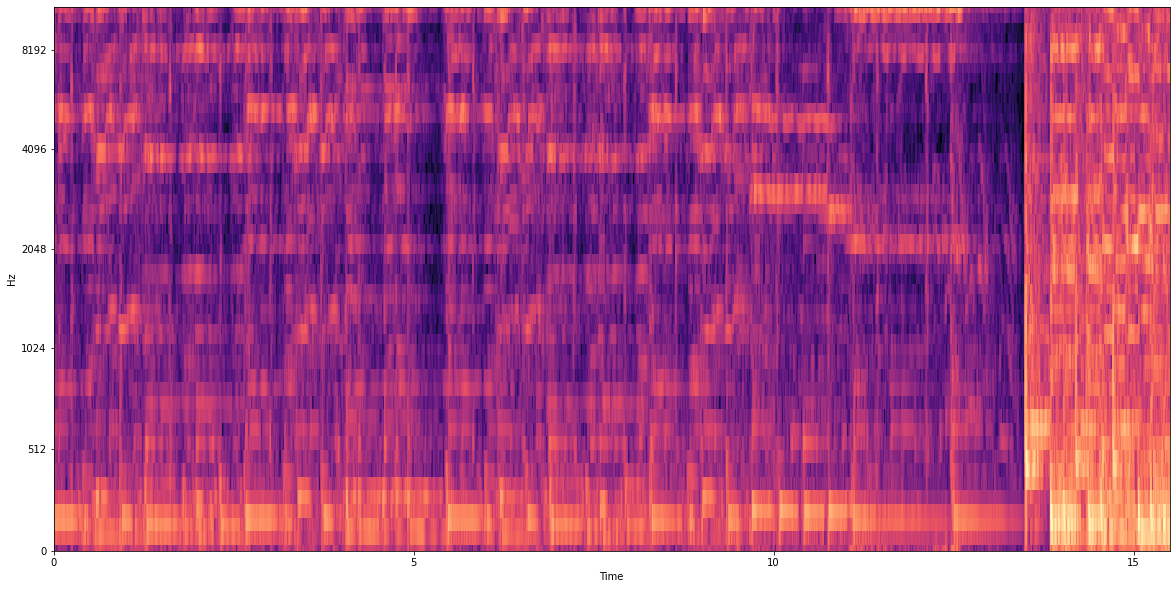

In [56]:
lb.display.specshow(mb_spec[:50,0:1550,0], sr=44100, hop_length=441,
                    x_axis = 'time' , y_axis = 'mel')

In [ ]:
np.logical_not()

In [ ]:
m,n = 20,7
prob = 0.05
rand_labels = (np.random.rand(m,n) <= prob).astype(np.int)
rand_logits = np.random.rand(m,n)
weigh =  np.array([prob for _ in range (n)], dtype=np.float32)
print(rand_labels)
print(rand_logits)
print(weigh, weigh.shape)


losses = tf.nn.weighted_cross_entropy_with_logits(labels = rand_labels.astype(np.float32),
                                                logits = tf.dtypes.cast(rand_logits, np.float32),
                                                 pos_weight = weigh)
print(losses)

## Testing of the train.py

In [ ]:
from train import *
main()

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


...Concatenating all music-aligned dataframes
...Replacing NaNs with - for output
---dataframe.describe() without blank_chars---
           tk     BD    SD    HH    RD    CC    C2   LT   MT   HT  CH   C3  SC
count   49917  11829  7624  5388  1718  3279  2334  994  391  298  97  302  26
unique      9      3     8     9     5     4     4    5    4    4   3    3   2
top         +      o     o     x     x     X     X    o    o    o   X    X   X
freq    12461  11356  6527  2905  1090  2016  1891  888  315  249  81  264  20

---Unique values and frequencies by column name---
        +      e      a     1     2     3     4   t   s
tk  12461  12459  12446  3206  3202  3199  2867  47  30

        -      o    O   d
BD  38088  11356  430  43

        -     o    g    O    f   d   r   x  0
SD  42293  6527  527  271  136  75  73  14  1

        -     x     X    o   O   s   g  S  d  w
HH  44529  2905  2186  195  35  32  26  5  2  2

        -     x    X    b   g   f
RD  48199  1090  476  113  25  14


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


---dataframe.describe() without blank_chars---
           tk     BD    SD    HH    at    ac
count   12474  11829  7024  2907  1540  9801
unique      2      1     1     1     1     1
top         c      o     o     x     o     x
freq     9268  11829  7024  2907  1540  9801

---Unique values and frequencies by column name---
        -     c     C
tk  37443  9268  3206

        -      o
BD  38088  11829

        -     o
SD  42893  7024

        -     x
HH  47010  2907

        -     o
at  48377  1540

        -     x
ac  40116  9801

one_hot_encode: col_list before encoding = ['tk', 'BD', 'SD', 'HH', 'at', 'ac']
one_hot_encode: col_list after encoding = ['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o', 'HH_x', 'at_o', 'ac_x']
train.py main(): FullSet_encoded created!
train.py main():  [0.0110785  0.00289334 0.01048125 0.00619243 0.0025786  0.00138979
 0.00866485]
train.py main(): drum_tabber model created!
Model: "model"
______________________________________________

Epoch: 1 Song  7/23, lr:0.000030, song_loss:1.544223
Error_df: 
               P     N  TP    TN  FP   FN     EX
tk_beat      462  1386  13  1384   2  449 -415.0
tk_downbeat  136  1712   6  1704   8  130  -74.0
BD_o         301  1547   1  1540   7  300 -277.0
SD_o         271  1577   2  1568   9  269 -214.0
HH_x         473  1375   3  1370   5  470 -427.0
at_o          79  1769   0  1761   8   79  -49.0
ac_x         218  1630   6  1615  15  212 -145.0
Accuracy: 
tk_beat        0.755952
tk_downbeat    0.925325
BD_o           0.833874
SD_o           0.849567
HH_x           0.742965
at_o           0.952922
ac_x           0.877165
dtype: float64
F1 Score: 
tk_beat        0.054507
tk_downbeat    0.080000
BD_o           0.006472
SD_o           0.014184
HH_x           0.012474
at_o           0.000000
ac_x           0.050209
dtype: float64
Epoch: 1 Song  8/23, lr:0.000035, song_loss:1.250590
Error_df: 
               P    N  TP   TN  FP   FN     EX
tk_beat      152  456  10  454   2  142 -112.

Epoch: 1 Song 17/23, lr:0.000074, song_loss:1.348035
Error_df: 
               P     N   TP    TN   FP   FN     EX
tk_beat      496  1488   48  1398   90  448  -97.0
tk_downbeat  124  1860   37  1759  101   87  275.0
BD_o         665  1319  127  1309   10  538 -167.0
SD_o         459  1525  139  1508   17  320  -87.0
HH_x           0  1984    0  1894   90    0  224.0
at_o          67  1917    0  1885   32   67  221.0
ac_x         567  1417  112  1367   50  455 -158.0
Accuracy: 
tk_beat        0.728831
tk_downbeat    0.905242
BD_o           0.723790
SD_o           0.830141
HH_x           0.954637
at_o           0.950101
ac_x           0.745464
dtype: float64
F1 Score: 
tk_beat        0.151420
tk_downbeat    0.282443
BD_o           0.316708
SD_o           0.452033
HH_x           0.000000
at_o           0.000000
ac_x           0.307270
dtype: float64
Epoch: 1 Song 18/23, lr:0.000078, song_loss:1.307020
Error_df: 
               P     N   TP    TN   FP   FN     EX
tk_beat      494  1478  1

Epoch: 2 Song  3/23, lr:0.000100, song_loss:1.277458
Error_df: 
               P     N   TP    TN   FP   FN     EX
tk_beat      628  1884  167  1741  143  461  267.0
tk_downbeat  157  2355   42  2086  269  115  667.0
BD_o         658  1854  239  1807   47  419   78.0
SD_o         323  2189   61  2110   79  262  166.0
HH_x         129  2383   24  2193  190  105  560.0
at_o          77  2435    0  2340   95   77  323.0
ac_x         334  2178   83  2021  157  251  438.0
Accuracy: 
tk_beat        0.759554
tk_downbeat    0.847134
BD_o           0.814490
SD_o           0.864252
HH_x           0.882564
at_o           0.931529
ac_x           0.837580
dtype: float64
F1 Score: 
tk_beat        0.356077
tk_downbeat    0.179487
BD_o           0.506356
SD_o           0.263499
HH_x           0.139942
at_o           0.000000
ac_x           0.289199
dtype: float64
Epoch: 2 Song  4/23, lr:0.000100, song_loss:1.097667
Error_df: 
               P     N  TP    TN  FP   FN     EX
tk_beat      368  1110  27 

Epoch: 2 Song 13/23, lr:0.000098, song_loss:1.156131
Error_df: 
               P     N   TP    TN   FP   FN     EX
tk_beat      787  2363  287  2209  154  500  333.0
tk_downbeat  196  2954   71  2576  378  125  926.0
BD_o         789  2361  304  2319   42  485  141.0
SD_o         342  2808  146  2736   72  196  257.0
HH_x          30  3120    7  2901  219   23  598.0
at_o          42  3108    4  2838  270   38  852.0
ac_x         586  2564  186  2361  203  400  469.0
Accuracy: 
tk_beat        0.792381
tk_downbeat    0.840317
BD_o           0.832698
SD_o           0.914921
HH_x           0.923175
at_o           0.902222
ac_x           0.808571
dtype: float64
F1 Score: 
tk_beat        0.467427
tk_downbeat    0.220155
BD_o           0.535683
SD_o           0.521429
HH_x           0.054688
at_o           0.025316
ac_x           0.381538
dtype: float64
Epoch: 2 Song 14/23, lr:0.000098, song_loss:1.258873
Error_df: 
               P     N  TP    TN  FP   FN     EX
tk_beat      468  1404  38 

Epoch: 2 Song 23/23, lr:0.000095, song_loss:1.034028
Error_df: 
               P     N   TP    TN   FP   FN     EX
tk_beat      360  1080  120   948  132  240  397.0
tk_downbeat   90  1350   29  1168  182   61  589.0
BD_o         315  1125   58  1073   52  257  151.0
SD_o         193  1247   74  1091  156  119  317.0
HH_x         251  1189  153  1076  113   98  380.0
at_o          22  1418    4  1188  230   18  605.0
ac_x         326  1114   32   911  203  294  455.0
Accuracy: 
tk_beat        0.741667
tk_downbeat    0.831250
BD_o           0.785417
SD_o           0.809028
HH_x           0.853472
at_o           0.827778
ac_x           0.654861
dtype: float64
F1 Score: 
tk_beat        0.392157
tk_downbeat    0.192691
BD_o           0.272941
SD_o           0.349882
HH_x           0.591876
at_o           0.031250
ac_x           0.114082
dtype: float64


Epoch:  2 val_loss:1.176593 


Val Error_df: 
                P     N   TP    TN   FP   FN      EX
tk_beat      1133  3401  363  3220  181

### Loading back in a saved model, configs_dict, and sample song

In [7]:
# load a model back in 
model_to_load_name = 'Context-CNN-E8-VL1_23776'
loaded_model, loaded_configs = load_drum_tabber_model(model_to_load_name, SAVED_MODELS_PATH)
print(loaded_configs)

{'class_names_dict': {'0': 'tk_beat', '1': 'tk_downbeat', '2': 'BD_o', '3': 'SD_o', '4': 'HH_x', '5': 'at_o', '6': 'ac_x'}, 'num_classes': 7, 'num_features': 100, 'num_channels': 1, 'n_mels': 100, 'model_type': 'Context-CNN', 'window_size': 2048, 'hop_size': 441, 'shift_to_db': True, 'n_context_pre': 13, 'n_context_post': 13, 'include_fo_differential': False, 'positive_window_fraction': 0.1, 'negative_window_fraction': 0.1, 'tolerance_window': 20, 'classification_dict': {'clean_date': True, 'keep_dynamics': False, 'keep_bells': False, 'keep_toms_seperate': False, 'hihat_classes': 1, 'cymbal_classes': 1}, 'month_date': '-Nov-20'}


In [9]:
# load sample song and make spectrogram
song_to_test = 'four_years'
samp_song, sr_song = lb.core.load(os.path.join(SONGS_PATH,song_to_test,song_to_test+'.mp3'), sr=None, mono=True)
print(f'Number of samples in song is {samp_song.shape[0]}')
spectro = lb.feature.melspectrogram(np.asfortranarray(samp_song), sr = sr_song, n_fft=loaded_configs['window_size'], hop_length = loaded_configs['hop_size'], center = False, n_mels = loaded_configs['n_mels'], fmax= loaded_configs['fmax'])
if loaded_configs['shift_to_db']:
    spectro = lb.power_to_db(spectro, ref = np.max)
spectro_norm = (spectro - spectro.mean())/spectro.std()
spectrogram = spectro_norm.copy()
n_features, n_windows = spectrogram.shape
print(f'spectrogram shape is {spectrogram.shape}')
if loaded_configs['model_type'] == 'Context-CNN':

    pre_context, post_context = loaded_configs['n_context_pre'], loaded_configs['n_context_post']
    input_width = pre_context + 1 + post_context
    min_value = np.min(spectrogram)

    # assign into this np.array filled with the min values of the spectrogram (silence)
    input_array = np.full(shape = (n_windows, n_features, input_width), fill_value = min_value)

    for idx in range(n_windows):
        if idx - pre_context < 0:    # in a window where you would slice before the beginning
            start = pre_context-idx
            input_array[idx, :, start:] = spectrogram[:, 0:idx+post_context+1]
        elif idx + post_context+1 > n_windows: # in a window where you would slice past the end
            end = post_context+1 - (n_windows - idx)
            input_array[idx, :, :input_width-end] = spectrogram[:, idx-pre_context: n_windows ]
        else:    # in a "normal" middle window where you slice into the spectrogram normally
            input_array[idx, :,:] = spectrogram[:, idx-pre_context : idx+post_context+1]

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Number of samples in song is 11265408
spectrogram shape is (100, 25541)


In [11]:
# making predictions on the sample song
start_ind = 0
end_ind = start_ind + 4096
%time predictions = loaded_model(np.expand_dims(input_array,axis=-1)[start_ind:end_ind,:,:,:], training=False)
print(predictions.shape)

Wall time: 40.8 s
(4096, 7)


In [12]:
predictions.numpy().shape

(4096, 7)

[ 12  21  43  83  93 128 199 213 247 294 375 393 410 447 481]


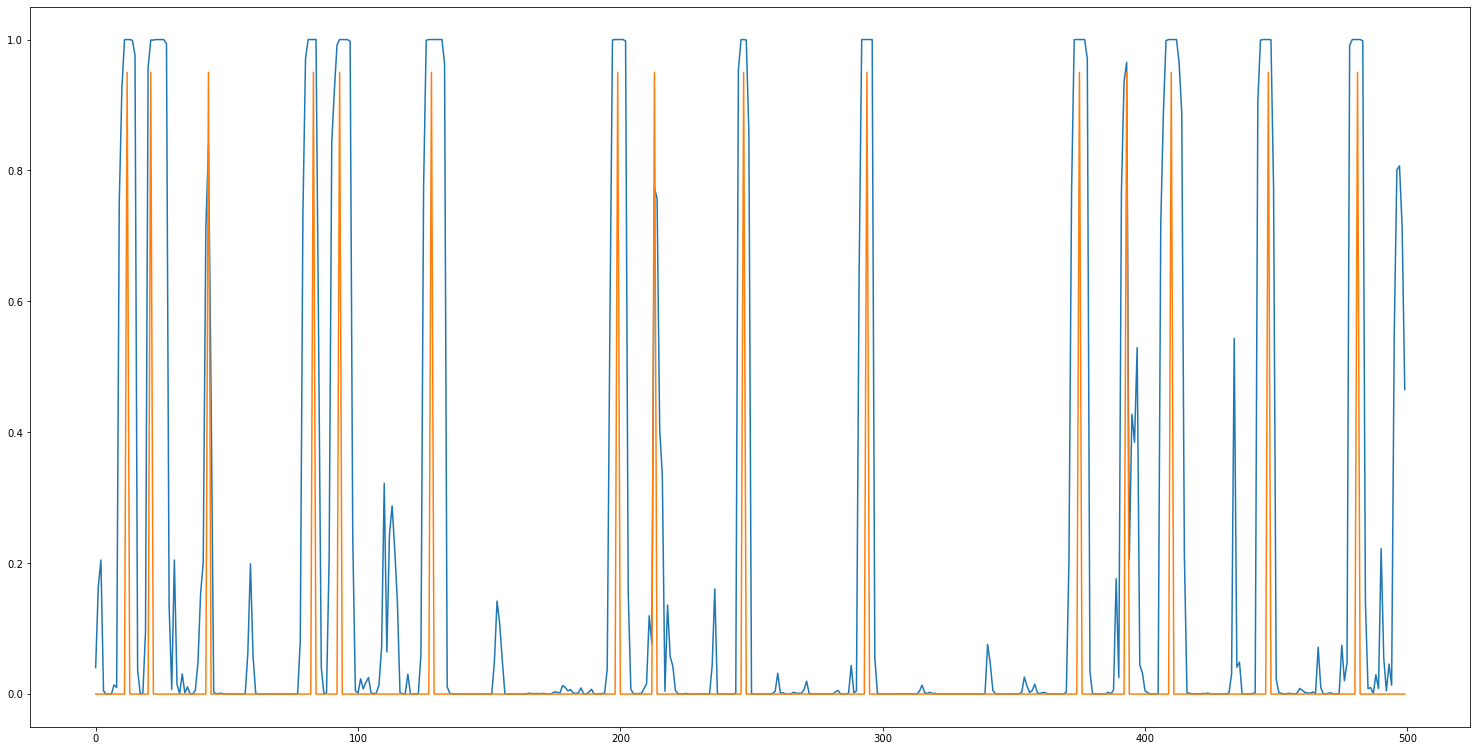

In [20]:
idx = 2 # {0:tk_beat, 1:tk_downbeat, 2:BD_o, 3:SD_o, 4:HH_x, 5:at_o, 6:ac_x}
diff_samples = 500
start = 1000
end = start + diff_samples
pred = predictions[start:end,idx].numpy()
pred_peaks = np.zeros(shape = pred.shape)

pred_peaks_idx = lb.util.peak_pick(x = pred, pre_max = 2, post_max = 2, pre_avg = 20, post_avg = 20, 
                              delta = 0.5, wait = 5)
print(pred_peaks_idx)
pred_peaks[pred_peaks_idx] = 0.95

# making a plot to output
plt.rcParams["figure.figsize"]=20,10
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(pred)
ax.plot(pred_peaks)
#ax.vlines(pred_peaks_idx, ymin=0, ymax=1, colors='r', alpha=0.8)


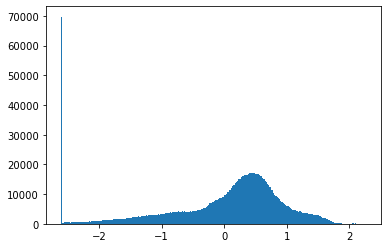

In [16]:
_ = plt.hist(spectrogram.flatten(), bins='auto')
plt.show()

In [ ]:
plt.hist(lb.feature.delta(data = normed_fy, width=9, order=1, axis=-1).flatten(), bins='auto')

In [ ]:
fy_ftd = lb.feature.delta(data = fy, width=9, order = 1, axis=-1)
_ = plt.hist(fy_ftd.flatten(), bins='auto')
plt.show()

In [334]:
class_names = [x for x in list(encode_df.columns) if '_' in x]
error_metrics_names = ['P', 'N', 'TP', 'FP', 'TN', 'FN']
error_df = pd.DataFrame(0, index=class_names, columns=error_metrics_names)

In [335]:
print(error_df)

             P  N  TP  FP  TN  FN
tk_beat      0  0   0   0   0   0
tk_downbeat  0  0   0   0   0   0
BD_o         0  0   0   0   0   0
SD_o         0  0   0   0   0   0
HH_x         0  0   0   0   0   0
at_o         0  0   0   0   0   0
ac_x         0  0   0   0   0   0


In [301]:
error_df.at['tk_downbeat','P'] += 1
print(error_df)

             P  N  TP  FP  TN  FN
tk_beat      0  0   0   0   0   0
tk_downbeat  1  0   0   0   0   0
BD_o         0  0   0   0   0   0
SD_o         0  0   0   0   0   0
HH_x         0  0   0   0   0   0
at_o         0  0   0   0   0   0
ac_x         0  0   0   0   0   0


In [302]:
sample_starts = np.array([0, 12, 24, 37, 39, 62, 89, 104, 132, 160, 190, 220, 250, 280])
print(len(sample_starts))

14


In [317]:
frame_starts = np.array([3*idx for idx in range(100)])
peaks = np.array(np.random.rand(100,len(class_names)) > 0.9, dtype=int)
print(peaks)

[[0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 

In [318]:
for num in sample_starts: 
    bool_mask = ((num-20) <= frame_starts) & (frame_starts <= (num + 20))
    print(bool_mask)

[ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[ True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False 

In [319]:
full_bool_mask = np.stack([((num-5) <= frame_starts) & (frame_starts <= (num + 5)) for num in sample_starts], axis=0)

In [320]:
full_bool_mask.shape   # num_rows_in_df, n_frames

(14, 100)

In [380]:
for idx in range(full_bool_mask.shape[0]):
    peaks_to_compare = peaks[full_bool_mask[idx,:],:]
    print(peaks_to_compare.shape)
    print(peaks_to_compare)
    bool_peak_in_frames_per_class = np.any(peaks_to_compare==1, axis=0)
    print('bool peak', bool_peak_in_frames_per_class)
    print('~bool peak', ~bool_peak_in_frames_per_class)
    print(np.array(labels[idx,:]==1 & bool_peak_in_frames_per_class, dtype=int))
    print(np.array(labels[idx,:]==0 & ~bool_peak_in_frames_per_class, dtype=int))
    '''
    for class_idx, names in enumerate(class_names):
        this_class = peaks_to_compare[:,class_idx]
        print(this_class)
    '''
        

(2, 7)
[[0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]
bool peak [ True False  True False False False False]
~bool peak [False  True False  True  True  True  True]
[1 0 1 1 1 1 0]
[0 0 0 1 1 1 0]
(3, 7)
[[0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
bool peak [False False False  True  True  True False]
~bool peak [ True  True  True False False False  True]
[1 1 1 0 0 0 1]
[1 1 1 1 1 1 1]
(3, 7)
[[0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 1 0 0]]
bool peak [ True False  True False  True False False]
~bool peak [False  True False  True False  True  True]
[0 1 0 1 1 1 1]
[1 1 1 1 0 1 1]
(4, 7)
[[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
bool peak [ True  True False False False False False]
~bool peak [False False  True  True  True  True  True]
[0 0 1 1 1 1 1]
[1 1 1 1 1 1 1]
(3, 7)
[[1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
bool peak [ True False False False False False False]
~bool peak [False  True  True  True  True  True  True]
[1 1 1 1 0 1 1]
[0 1 1 1 0 1 1]


In [248]:
encode_df = encode_df.drop(columns = ['song slice'])

In [249]:
encode_df.head()

,sample start,tk_beat,tk_downbeat,BD_o,SD_o,HH_x,at_o,ac_x
0,15611,1,1,1,0,0,0,1
1,19056,0,0,0,0,0,0,0
2,22501,0,0,0,0,1,0,0
3,25946,0,0,0,0,0,0,0
4,29391,1,0,0,0,1,0,0


In [250]:
class_names = [x for x in list(encode_df.columns) if '_' in x]

In [337]:
labels = encode_df[class_names].to_numpy()
print(labels[0,:])

[1 1 1 0 0 0 1]


In [351]:
P = np.sum(labels==1, axis=0)
N = np.sum(labels==0, axis=0)
print(P)
print(N)

[484 121 455 227 170 166 297]
[1452 1815 1481 1709 1766 1770 1639]
[1936 1936 1936 1936 1936 1936 1936]


In [359]:
print(error_df['P'])
error_df['P'] = P
error_df['N'] = N
print(error_df)

tk_beat        1452
tk_downbeat    1815
BD_o           1481
SD_o           1709
HH_x           1766
at_o           1770
ac_x           1639
Name: P, dtype: int32
               P     N  TP  FP  TN  FN
tk_beat      484  1452   0   0   0   0
tk_downbeat  121  1815   0   0   0   0
BD_o         455  1481   0   0   0   0
SD_o         227  1709   0   0   0   0
HH_x         170  1766   0   0   0   0
at_o         166  1770   0   0   0   0
ac_x         297  1639   0   0   0   0


In [385]:
error_df['TP'] += np.array([False, True, True, False, True, False, False])
print(error_df)

               P     N  TP  FP  TN  FN
tk_beat      484  1452   0   0   0   0
tk_downbeat  121  1815   4   0   0   0
BD_o         455  1481   4   0   0   0
SD_o         227  1709   0   0   0   0
HH_x         170  1766   4   0   0   0
at_o         166  1770   0   0   0   0
ac_x         297  1639   0   0   0   0


In [389]:
error_df_list = [error_df, error_df, error_df]
true_error_df = error_df_list[0].copy()
print(true_error_df)

               P     N  TP  FP  TN  FN
tk_beat      484  1452   0   0   0   0
tk_downbeat  121  1815   4   0   0   0
BD_o         455  1481   4   0   0   0
SD_o         227  1709   0   0   0   0
HH_x         170  1766   4   0   0   0
at_o         166  1770   0   0   0   0
ac_x         297  1639   0   0   0   0


In [392]:
final_error_df = sum(error_df_list).copy()

In [393]:
final_error_df

,P,N,TP,FP,TN,FN
tk_beat,1452,4356,0,0,0,0
tk_downbeat,363,5445,12,0,0,0
BD_o,1365,4443,12,0,0,0
SD_o,681,5127,0,0,0,0
HH_x,510,5298,12,0,0,0
at_o,498,5310,0,0,0,0
ac_x,891,4917,0,0,0,0


In [395]:
accuracy = print(final_error_df['TP'] / final_error_df['P'])

tk_beat        0.000000
tk_downbeat    0.033058
BD_o           0.008791
SD_o           0.000000
HH_x           0.023529
at_o           0.000000
ac_x           0.000000
dtype: float64


In [25]:
globalstep = 34
test_n = (globalstep % 34) if (globalstep % 34) != 0 else 34
print(test_n)

34
